In [17]:
!pip install matplotlib

import librosa
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
audio, sr = librosa.load("Misirlou.wav", sr = 16000)

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)


Matplotlib is building the font cache; this may take a moment.


In [31]:
spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048) 
M = abs(spectrogram)
phase = spectrogram/(M + 2.2204e-16)

In [33]:
file_paths = [
    'notes_scale/0.wav',
    'notes_scale/1.wav',
    'notes_scale/2.wav',
    'notes_scale/3.wav',
    'notes_scale/4.wav',
    'notes_scale/5.wav',
    'notes_scale/6.wav'
]
def process_wav_librosa(file_path):
    # Load the audio file
    data, rate = librosa.load(file_path, sr=16000)
    
    # Compute the Short-Time Fourier Transform (STFT)
    S = abs(librosa.stft(data,n_fft=2048, hop_length=256, center=False, win_length=2048))
    
    # Extract the middle column (STFT is frequency x time, we want the middle time column)
    middle = S[:, int(math.ceil(S.shape[1]/2))]
    middle[middle < (max(middle)/100)] = 0
    middle = middle/np.linalg.norm(middle)
    
    return middle

# Process all WAV files using librosa and store the resulting vectors
spectrogram_vectors_librosa = [process_wav_librosa(file_path) for file_path in file_paths]

In [35]:
Notes=np.array(spectrogram_vectors_librosa)
Notes=Notes.T

In [37]:
W_init = np.zeros((Notes.shape[1], M.shape[1]))
learning_rates = [100, 1000, 10000, 100000]
num_iterations = 1000
optimal_weights = None
minimum_error = float('inf')
error_log = {}
num_samples, num_targets = M.shape
all_errors_list = []

def calculate_reconstruction_error(M, Notes, Weights):
    return np.linalg.norm(M - np.dot(Notes, Weights), 'fro') ** 2

def calculate_gradient(M, Notes, Weights, num_samples, num_targets):
    return (2 / (num_samples * num_targets)) * np.dot(Notes.T, np.dot(Notes, Weights) - M)

def optimize_weights(M, Notes, W_init, lr, num_iterations, num_samples, num_targets):
    Weights = W_init.copy()
    error_history = []
    for iteration in range(num_iterations):
        grad = calculate_gradient(M, Notes, Weights, num_samples, num_targets)
        updated_weights = Weights - lr * grad
        Weights = np.maximum(updated_weights, 0)
        error = calculate_reconstruction_error(M, Notes, Weights)
        error_history.append(error)
    return Weights, error_history




In [39]:
for eta in learning_rates:
    W, errors = optimize_weights(M, Notes, W_init, eta, num_iterations, num_samples, num_targets)
    all_errors_list.append(errors)
    final_error = errors[-1]
    error_log[eta] = final_error
    if final_error < minimum_error:
        minimum_error = final_error
        optimal_weights = W

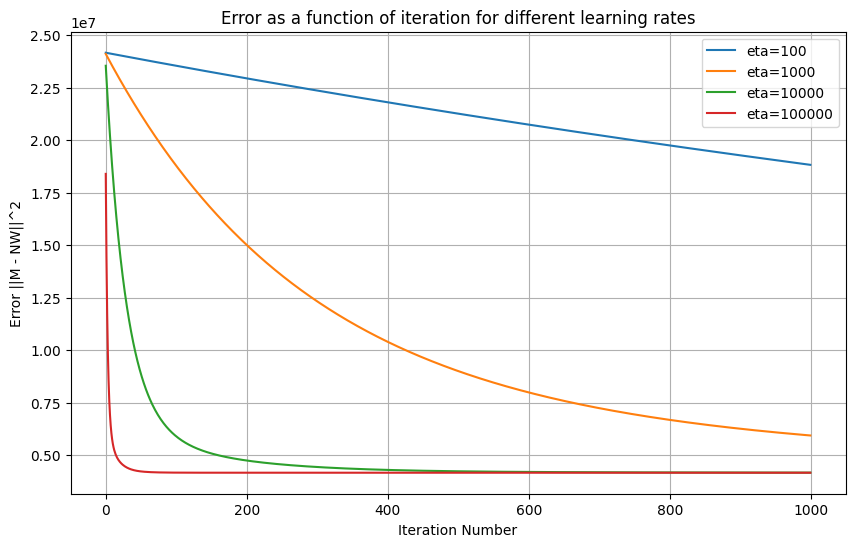

In [41]:
plt.figure(figsize=(10, 6))
for i, eta in enumerate(etas):
    plt.plot(all_errors[i], label=f'eta={eta}')
plt.xlabel('Iteration Number')
plt.ylabel('Error ||M - NW||^2')
plt.title('Error as a function of iteration for different learning rates')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
df = pd.DataFrame(optimal_weights, columns=None)  

df.to_csv('problem2W.csv', index=False)  


In [47]:
import soundfile as sf
import IPython.display as ipd


M_hat = Notes @ optimal_weights
M_hat_spectogram = M_hat * np.exp(1j*phase) 

Y_hat = librosa.istft(M_hat_spectogram, hop_length=256, win_length=2048, center=False)
print(Y_hat)

sf.write('resynthesized_nnproj.wav', Y_hat, 16000)
ipd.Audio('resynthesized_nnproj.wav', rate=16000)

[   0.          458.79428944  113.5614291  ...  464.41104292 1049.91268402
 4186.42433919]


In [ ]:
"This audio file is better then resythensized proj.wav file. 
It is more approximate to the Misirlou.wau file. Because of getting best 
weight matrix the reconstruction is lot closer to original file."